In [1]:
# Run this in a notebook cell to install a stable version of pyarrow
# import sys
# import subprocess

# # Uninstall the current broken version
# subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "pyarrow", "-y"])

# # Install a stable version (16.1.0)
# subprocess.check_call([sys.executable, "-m", "pip", "install", "pyarrow==16.1.0"])

In [2]:
import pandas as pd
import numpy as np
import re
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('property_listing_data_in_Bangladesh.csv')

In [4]:
# Count missing values in each column
missing_values = df.isnull().sum()

# Display the result
print(missing_values)

title          0
beds           0
bath           0
area           0
address        0
type           0
purpose        0
flooPlan       1
url            0
lastUpdated    0
price          0
dtype: int64


In [5]:
# -------------------------------------------------
# 1. PREMIUM AREA
# -------------------------------------------------
premium_areas = [
    'Gulshan', 'Banani', 'Baridhara', 'Uttara Sector 13',
    'Dhanmondi', 'Mirpur DOHS', 'Mohakshali DOHS', 'Khulshi',
    'Rajuk Uttara Apartment Project', 'Panchlaish', 'Jamal Khan', 'Lal Khan Bazaar',
    'Bagmoniram'
]

df['is_premium_area'] = df['title'].apply(
    lambda t: int(any(area in t for area in premium_areas))
)

# -------------------------------------------------
# 2. CONDITION (medium‑value predictor)
# -------------------------------------------------
condition_keywords = [
    'Strongly Structured', 'Tastefully Designed', 'Strongly Constructed',
    'Well-Constructed', 'Elegant', 'Spacious', 'Excellent',
    'Marvelous', 'Perfect', 'Smartly Priced'
]

df['is_high_condition'] = df['title'].apply(
    lambda t: int(any(word in t for word in condition_keywords))
)

# -------------------------------------------------
# 3. FURNISHED (high‑value indicator)
# -------------------------------------------------
df['is_fully_furnished'] = df['title'].str.contains(
    'Fully Furnished', case=False, na=False
).astype(int)

# -------------------------------------------------
# 5. LUXURY & VIEW (luxury indicator)
# -------------------------------------------------
def is_luxury(title: str) -> int:
    """Return 1 if any luxury‑related keyword appears in the title."""
    luxury_keywords = [
        'Open Sky View',
        'Penthouse', 
        'Sky View'
    ]
    return int(any(word in title for word in luxury_keywords))

df['is_luxury'] = df['title'].apply(is_luxury)

# -------------------------------------------------
# Sample output
# -------------------------------------------------
print("Sample of extracted features:")
print(df[['title',
          'is_premium_area',
          'is_high_condition',
          'is_fully_furnished',
          'is_luxury',
          'beds']].head(10))

Sample of extracted features:
                                               title  is_premium_area  \
0  Eminent Apartment Of 2200 Sq Ft Is Vacant For ...                0   
1  Apartment Ready To Rent In South Khulshi, Near...                1   
2  Smartly priced 1950 SQ FT apartment, that you ...                0   
3  2000 Sq Ft Residential Apartment Is Up For Ren...                0   
4  Strongly Structured This 1650 Sq. ft Apartment...                0   
5  A nice residential flat of 3400 SQ FT, for ren...                1   
6  1600 Square Feet Apartment With Amazing Rooms ...                0   
7  Let Us Help You To Rent This 1250 Sq Ft Apartm...                0   
8  An Extensive Apartment Of 2150 Sq Ft Is Vacant...                0   
9  A well-constructed 1250 SQ FT apartment is rea...                0   

   is_high_condition  is_fully_furnished  is_luxury beds  
0                  0                   0          0    3  
1                  0                   0        

In [6]:
df['area'] = df['area'].astype(str)
df['area'] = df['area'].str.replace(',', '', regex=False)
df['area'] = df['area'].str.replace(' sqft', '', regex=False)
df['area'] = pd.to_numeric(df['area'], errors='coerce')
df = df.dropna(subset=['area'])

In [7]:
df['area_log'] = np.log1p(df['area'])
df['area_x_premium'] = df['area'] * df['is_premium_area']
df['area_x_furnished'] = df['area'] * df['is_fully_furnished']

In [8]:
# # assume df is your DataFrame
# unique_addresses = df['address'].dropna().unique()   # remove NaNs if any

# # ── Print to console ─────────────────────────────────────
# for addr in unique_addresses:
#     print(addr)

# # ── Save to a text file (one address per line) ─────────────────────
# with open('unique_addresses.txt', 'w', encoding='utf-8') as f:
#     for addr in unique_addresses:
#         f.write(f"{addr}\n")

In [9]:
df['city'] = df['address'].apply(lambda x: str(x).split(',')[-1].strip())

In [10]:
df['beds'] = pd.to_numeric(df['beds'], errors='coerce')
df['bath'] = pd.to_numeric(df['bath'], errors='coerce')

In [11]:
median_beds = df['beds'].median()
median_bath = df['bath'].median()

In [12]:
df['beds'] = df['beds'].fillna(median_beds)
df['bath'] = df['bath'].fillna(median_bath)

In [13]:
df['baths_per_bed'] = df['bath'] / (df['beds'] + 1e-6)
df['beds_minus_baths'] = df['beds'] - df['bath']
df['total_rooms'] = df['beds'] + df['bath']
df['beds_times_bath'] = df['beds'] * df['bath']

In [14]:
print(df.isnull().sum())

title                 0
beds                  0
bath                  0
area                  0
address               0
type                  0
purpose               0
flooPlan              1
url                   0
lastUpdated           0
price                 0
is_premium_area       0
is_high_condition     0
is_fully_furnished    0
is_luxury             0
area_log              0
area_x_premium        0
area_x_furnished      0
city                  0
baths_per_bed         0
beds_minus_baths      0
total_rooms           0
beds_times_bath       0
dtype: int64


In [15]:
df.columns

Index(['title', 'beds', 'bath', 'area', 'address', 'type', 'purpose',
       'flooPlan', 'url', 'lastUpdated', 'price', 'is_premium_area',
       'is_high_condition', 'is_fully_furnished', 'is_luxury', 'area_log',
       'area_x_premium', 'area_x_furnished', 'city', 'baths_per_bed',
       'beds_minus_baths', 'total_rooms', 'beds_times_bath'],
      dtype='object')

In [16]:
# 4. Clean Price & Area
def convert_price_to_number(price):
    """
    Converts a price string (potentially with mixed units like Lakh/Thousand/Crore)
    into a single float value.
    """
    # 1. Handle if input is already a number (int or float)
    if isinstance(price, (int, float)):
        return float(price)
    
    # 2. Handle non-string inputs (e.g., NaN or None)
    if not isinstance(price, str):
        return 0.0
        
    # 3. Normalize string: lowercase and remove commas
    price = price.lower().replace(',', '')
    
    # 4. Define multipliers (Added 'Crore' as it is common in Bangladesh)
    multipliers = {
        'crore': 10000000,
        'lakh': 100000,
        'million': 1000000,
        'thousand': 1000,
        'k': 1000
    }
    
    # 5. Regex Pattern:
    # (\d+(?:\.\d+)?) -> Matches integers or decimals (Group 1)
    # \s*             -> Matches optional whitespace
    # (crore|lakh|...)? -> Matches optional unit keywords (Group 2)
    pattern = re.compile(r'(\d+(?:\.\d+)?)\s*(crore|lakh|million|thousand|k)?')
    
    total = 0.0
    matches = pattern.findall(price)
    
    for num_str, unit in matches:
        value = float(num_str)
        if unit in multipliers:
            total += value * multipliers[unit]
        else:
            # If no unit is specified, assume it is in the base currency (e.g. Taka)
            total += value
            
    return total

df['price'] = df['price'].apply(convert_price_to_number)

In [17]:
# -------------------------------------------------
# ADVANCED FILTERING: REMOVING UNICORNS
# -------------------------------------------------

# 1. Filter 1: Cap the maximum rental price
# Most people in Bangladesh prefer rental homes priced below 35,000 BDT,
# as rising inflation and economic instability make affordable housing a priority.
# Anything over 35,000 BDT is unaffordable for the majority today,
# let alone 100,000 BDT.
# These higher‑priced listings also skew the model for standard rentals.
MAX_PRICE_CAP = 100000
df = df[df['price'] < MAX_PRICE_CAP]
print(f"Filtered properties > {MAX_PRICE_CAP}: {len(df)} rows remaining")

# 2. Filter 2: Minimum Area per Bedroom (Sanity Check)
# A standard bedroom + bath needs at least ~160 sqft.
# If 'area' / 'beds' is less than this, the data is likely wrong (e.g. 700 sqft with 5 beds).
MIN_SQFT_PER_BED = 160
df = df[df['area'] / df['beds'] > MIN_SQFT_PER_BED]
print(f"Filtered impossible density (low area/bed ratio): {len(df)} rows remaining")

# 3. Filter 3: Maximum Price per Sq Ft
# If an apartment costs more than 100 BDT per sqft, it is likely a serviced apartment or short-term rental.
# model is built for standard long-term rent.
MAX_PRICE_PER_SQFT = 100
df['price_per_sqft'] = df['price'] / df['area']
df = df[df['price_per_sqft'] < MAX_PRICE_PER_SQFT]
print(f"Filtered extreme Price/SqFt: {len(df)} rows remaining")

df = df.drop('price_per_sqft', axis=1)

Filtered properties > 100000: 7131 rows remaining
Filtered impossible density (low area/bed ratio): 7102 rows remaining
Filtered extreme Price/SqFt: 7101 rows remaining


In [18]:
cols_to_drop = ['title', 'purpose', 'flooPlan', 'url', 'lastUpdated']
df = df.drop(cols_to_drop, axis=1)

In [19]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [20]:
X = df.drop(['price'], axis=1)
y = df['price']
y_log = np.log1p(y)

In [21]:
X_train, X_rem, y_train_log, y_rem_log = train_test_split(X, y_log, train_size=0.6, random_state=42)
X_val, X_test, y_val_log, y_test_log = train_test_split(X_rem, y_rem_log, test_size=0.5, random_state=42)

In [22]:
train_combined = X_train.copy()
train_combined['price'] = np.expm1(y_train_log)
mean_map_address = train_combined.groupby('address')['price'].mean()
global_mean_address = train_combined['price'].mean()

mean_map_city = train_combined.groupby('city')['price'].mean()
global_mean_city = train_combined['price'].mean()

In [23]:
def encode_features(data, map_addr, glob_addr, map_city, glob_city):
    data_copy = data.copy()
    data_copy['address_encoded'] = data_copy['address'].map(map_addr).fillna(glob_addr)
    data_copy['city_encoded'] = data_copy['city'].map(map_city).fillna(glob_city)
    data_copy.drop(['address', 'city'], axis=1, inplace=True)
    return data_copy

X_train_enc = encode_features(X_train, mean_map_address, global_mean_address, mean_map_city, global_mean_city)
X_val_enc   = encode_features(X_val, mean_map_address, global_mean_address, mean_map_city, global_mean_city)
X_test_enc  = encode_features(X_test, mean_map_address, global_mean_address, mean_map_city, global_mean_city)

In [24]:
model_final = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    
    num_leaves=20,           
    min_data_in_leaf=100,      
    max_depth=-1,              
    learning_rate=0.02,       
    n_estimators=5000,        
    reg_alpha=0.5,           
    reg_lambda=0.5,           
    feature_fraction=0.8,    
    bagging_fraction=0.8,   
    bagging_freq=5,
    
    random_state=42,
    verbose=-1
)

In [25]:
model_final.fit(
    X_train_enc, 
    y_train_log,
    eval_set=[(X_val_enc, y_val_log)],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

,boosting_type,'gbdt'
,num_leaves,20
,max_depth,-1
,learning_rate,0.02
,n_estimators,5000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [26]:
y_train_actual = np.expm1(y_train_log)
y_val_actual = np.expm1(y_val_log)

y_train_pred = np.expm1(model_final.predict(X_train_enc))
y_val_pred = np.expm1(model_final.predict(X_val_enc))

train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))

avg_price = np.mean(y_train_actual)

print("="*40)
print("FINAL REGULARIZED MODEL PERFORMANCE")
print("="*40)
print(f"Training RMSE: {train_rmse:,.2f} ({(train_rmse/avg_price)*100:.2f}%)")
print(f"Validation RMSE: {val_rmse:,.2f} ({(val_rmse/avg_price)*100:.2f}%)")
print("-" * 40)

FINAL REGULARIZED MODEL PERFORMANCE
Training RMSE: 4,993.35 (21.41%)
Validation RMSE: 5,983.81 (25.66%)
----------------------------------------


In [27]:
diff = val_rmse - train_rmse
print(f"Gap (Val - Train): {diff:,.2f}")

if diff > 1000:
    print("Status: Still Overfitting (Gap is wide)")
elif diff < 500:
    print("Status: Stable (Gap is small)")
else:
    print("Status: Balanced")

Gap (Val - Train): 990.46
Status: Balanced



--- Top 10 Important Features ---
            Feature  Importance
16  address_encoded       12521
2              area        8207
7          area_log        2089
10    baths_per_bed         922
12      total_rooms         563
8    area_x_premium         533
17     city_encoded         480
1              bath         320
0              beds         210
13  beds_times_bath         136


C:\Users\ahsbd\AppData\Local\Temp\ipykernel_11676\1096917027.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df.head(15), palette='viridis')


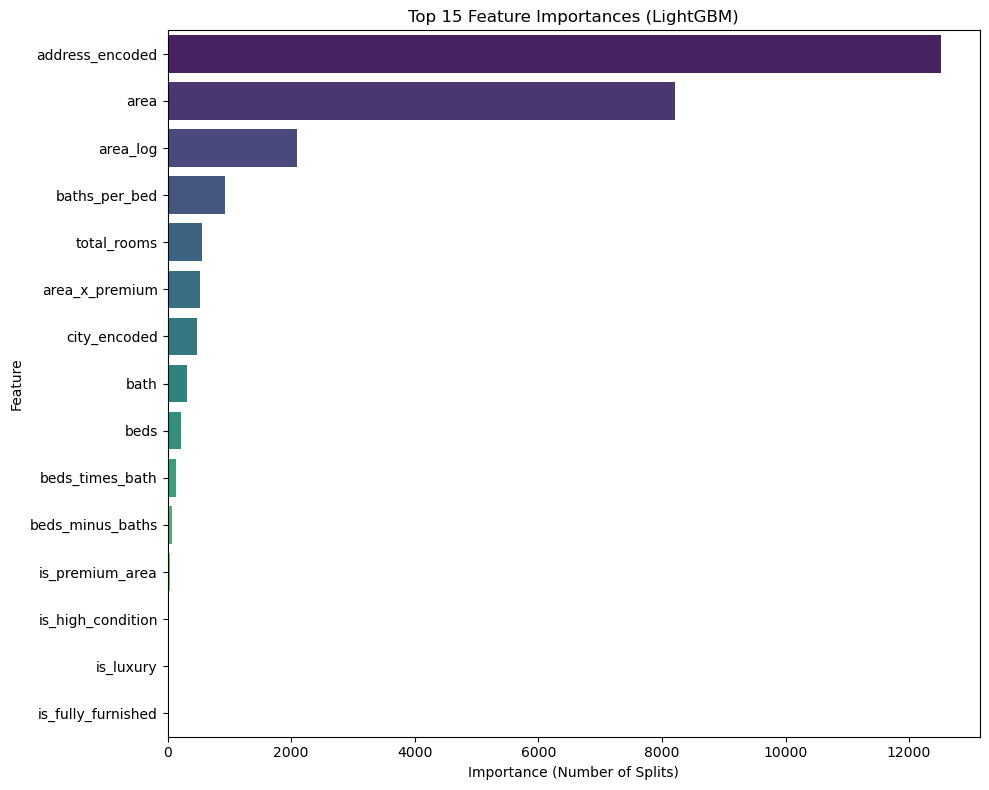

In [28]:
importance = model_final.feature_importances_
feature_names = X_train_enc.columns

# Create a DataFrame to hold the results
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("\n--- Top 10 Important Features ---")
print(fi_df.head(10))

# Plot Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importances (LightGBM)')
plt.xlabel('Importance (Number of Splits)')
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.tight_layout()
plt.show()

In [29]:
import joblib
import os

# 1. Create a directory to save the model
if not os.path.exists('rental_model_package'):
    os.makedirs('rental_model_package')

# 2. Save the LightGBM Model
joblib.dump(model_final, 'rental_model_package/lgbm_model.pkl')

# 3. Save the Target Encoders (Crucial!)
# We need these to convert addresses to numbers in the future
joblib.dump(mean_map_address, 'rental_model_package/address_encoder.pkl')
joblib.dump(mean_map_city, 'rental_model_package/city_encoder.pkl')

# 4. Save the global means (fallback values)
joblib.dump(global_mean_address, 'rental_model_package/global_mean_address.pkl')
joblib.dump(global_mean_city, 'rental_model_package/global_mean_city.pkl')

# 5. Save the column names (to ensure future inputs have the exact same structure)
joblib.dump(X_test_enc.columns.tolist(), 'rental_model_package/model_columns.pkl')

print("Model and encoders saved successfully in 'rental_model_package/' folder!")

Model and encoders saved successfully in 'rental_model_package/' folder!
